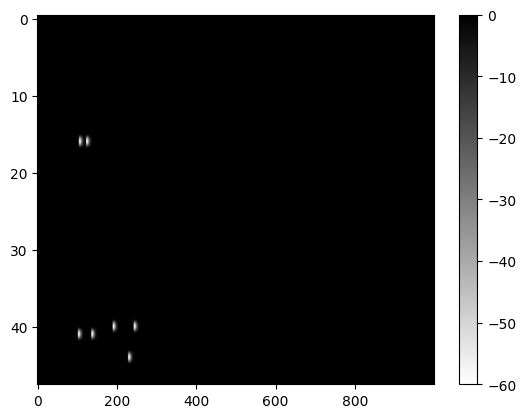

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch.nn.functional as F
import torch
from tqdm import trange
from math import ceil, floor, exp, sqrt, sin

waveform_LUT = np.load(
    "/sdf/data/neutrino/2x2/light_lut/light_wvfm_temp/light_wvfm_LUT_dEdx2_ix0_iy0.npy"
)

waveform_0 = waveform_LUT[32, :, :]
plt.imshow(waveform_0, aspect="auto", cmap="gray_r")
plt.colorbar()
plt.show()

In [203]:
import numba as nb
from larndsim.const import light, detector


@nb.njit
def interp(idx, arr, low, high):
    """
    Performs a simple linear interpolation of an array at a given floating point
    index

    Args:
        idx(float): index into array to interpolate
        arr(array): 1D array of values to interpolate
        low(float): value to return if index is less than 0
        high(float): value to return if index is above `len(arr)-1`

    Returns:
        float: interpolated array value
    """
    i0 = int(floor(idx))

    if i0 < 0:
        return low
    if i0 > len(arr) - 1:
        return high
    if i0 == idx:
        return arr[i0]
    if i0 > len(arr) - 2:
        return high

    i1 = i0 + 1
    v0 = arr[i0]
    v1 = arr[i1]

    return v0 + (v1 - v0) * (idx - i0)


@nb.njit
def scintillation_model(time_tick):
    """
    Calculates the fraction of scintillation photons emitted
    during time interval `time_tick` to `time_tick + 1`

    Args:
        time_tick(int): time tick relative to t0

    Returns:
        float: fraction of scintillation photons
    """
    p1 = (
        light.SINGLET_FRACTION
        * exp(-time_tick * light.LIGHT_TICK_SIZE / light.TAU_S)
        * (1 - exp(-light.LIGHT_TICK_SIZE / light.TAU_S))
    )
    p3 = (
        (1 - light.SINGLET_FRACTION)
        * exp(-time_tick * light.LIGHT_TICK_SIZE / light.TAU_T)
        * (1 - exp(-light.LIGHT_TICK_SIZE / light.TAU_T))
    )
    return (p1 + p3) * (time_tick >= 0)


@nb.njit
def sipm_response_model(idet, time_tick):
    """
    Calculates the SiPM response from a PE at `time_tick` relative to the PE time

    Args:
        idet(int): SiPM index
        time_tick(int): time tick relative to t0

    Returns:
        float: response
    """
    # use RLC response model
    if light.SIPM_RESPONSE_MODEL == 0:
        t = time_tick * light.LIGHT_TICK_SIZE
        impulse = (
            (t >= 0)
            * exp(-t / light.LIGHT_RESPONSE_TIME)
            * sin(t / light.LIGHT_OSCILLATION_PERIOD)
        )
        # normalize to 1
        impulse /= light.LIGHT_OSCILLATION_PERIOD * light.LIGHT_RESPONSE_TIME**2
        impulse *= light.LIGHT_OSCILLATION_PERIOD**2 + light.LIGHT_RESPONSE_TIME**2
        return impulse * light.LIGHT_TICK_SIZE

    # use measured response model
    if light.SIPM_RESPONSE_MODEL == 1:
        impulse = interp(
            time_tick * light.LIGHT_TICK_SIZE / light.IMPULSE_TICK_SIZE,
            light.IMPULSE_MODEL,
            0,
            0,
        )
        # normalize to 1
        impulse /= light.IMPULSE_TICK_SIZE / light.LIGHT_TICK_SIZE
        return impulse

In [204]:
@nb.njit
def calc_light_detector_response(light_sample_inc):
    """
    Simulates the SiPM reponse and digit

    Args:
        light_sample_inc(array): shape `(ndet, ntick)`, PE produced on each SiPM at each time tick
        light_response(array): shape `(ndet, ntick)`, ADC value at each time tick
    """

    light_response = np.zeros_like(light_sample_inc)

    for idet in range(light_sample_inc.shape[0]):
        for itick in range(light_sample_inc.shape[1]):
            conv_ticks = ceil(
                (light.LIGHT_WINDOW[1] - light.LIGHT_WINDOW[0]) / light.LIGHT_TICK_SIZE
            )

            for jtick in range(max(itick - conv_ticks, 0), itick + 1):
                tick_weight = sipm_response_model(idet, itick - jtick)
                light_response[idet, itick] += (
                    light.LIGHT_GAIN[idet] * tick_weight * light_sample_inc[idet, jtick]
                )

    return light_response


@nb.njit
def calc_scintillation_effect(light_sample_inc):
    """
    Applies a smearing effect due to the liquid argon scintillation time profile using
    a two decay component scintillation model.

    Args:
        light_sample_inc(array): shape `(ndet, ntick)`, light incident on each detector
        light_sample_inc_scint(array): output array, shape `(ndet, ntick)`, light incident on each detector after accounting for scintillation time
    """
    ndet, ntick = light_sample_inc.shape

    light_sample_inc_scint = np.zeros((ndet, 1000))

    for idet in range(ndet):
        for itick in range(ntick):
            conv_ticks = ceil(
                (light.LIGHT_WINDOW[1] - light.LIGHT_WINDOW[0]) / light.LIGHT_TICK_SIZE
            )

            for jtick in range(max(itick - conv_ticks, 0), itick + 1):
                if light_sample_inc[idet, jtick] == 0:
                    continue
                tick_weight = scintillation_model(itick - jtick)
                light_sample_inc_scint[idet, itick] += (
                    tick_weight * light_sample_inc[idet, jtick]
                )

    return light_sample_inc_scint

In [145]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from gplib import TPhotonLib
from photonlib.meta import VoxelMeta

with h5py.File("data/lightLUT_Mod0_06052024.h5", "r") as f:
    d_ = f["arr"][:]
d_["time_dist"].shape

(64, 128, 32, 48, 100)

In [222]:
# Code to sample from timing distribution

import numpy as np
import torch

X, Y, Z, C, T = d_["time_dist"].shape
waveform_dist = torch.tensor(d_["time_dist"].astype(np.float32))
waveform_dist_norm = F.normalize(waveform_dist.reshape(-1, C * T), p=1, dim=-1).reshape(
    X, Y, Z, C, T
)
waveform_dist_norm_center = waveform_dist_norm[32, 1, 16].numpy()

# Create a 2D grid for interpolation
m_grid, t_grid = np.meshgrid(np.arange(C), np.arange(T) * 10)  # t_grid in ns

# Compute cumulative distribution function (CDF)
cdf = np.cumsum(waveform_dist_norm_center.ravel())
cdf /= cdf[-1]  # Normalize CDF


def sample_timing_distribution(num_photon):
    u = np.random.rand(num_photon)
    sampled_idx = np.searchsorted(cdf, u)

    output = np.zeros_like(waveform_dist_norm_center)
    indexes, counts = np.unique(sampled_idx, return_counts=True)
    output.ravel()[indexes] = counts
    return output

In [217]:
light.SIPM_RESPONSE_MODEL = 0
light.LIGHT_TRIG_MODE = 1
light.OP_CHANNEL_PER_TRIG = 3


def get_triggers(signal):
    """
    Identifies each simulated ticks that would initiate a trigger taking into account the ADC digitization window

    Returns:
        tuple: array of tick indices at each trigger (shape `(ntrigs,)`) and array of op channel index (shape `(ntrigs, ndet_module)`)
    """

    op_channel_idx = np.arange(48)
    trigger_idx_list = [np.asarray(0)]
    op_channel_idx_list = [np.asarray(op_channel_idx)]
    trigger_type_list = [np.asarray(1)]

    if len(trigger_idx_list):
        return (
            np.array(trigger_idx_list),
            np.array(op_channel_idx_list),
            np.array(trigger_type_list),
        )
    return (
        np.empty((0,), dtype=int),
        np.empty((0, len(op_channel_idx)), dtype=int),
        np.empty((0,), dtype=int),
    )

In [218]:
@nb.njit
def digitize_signal(signal, signal_op_channel_idx, trigger_idx, trigger_op_channel_idx, signal_true_track_id, signal_true_photons, digit_signal, digit_signal_true_track_id, digit_signal_true_photons):
    """
    Interpolate signal to the appropriate sampling frequency
    
    Args:
        signal(array): shape `(ndet, nticks)`, simulated signal on each channel
        signal_op_channel_idx(array): shape `(ndet,)`, optical channel index for each simulated signal
        trigger_idx(array): shape `(ntrigs,)`, tick index for each trigger
        trigger_op_channel_idx(array): shape `(ntrigs, ndet_module)`, optical channel index for each trigger
        digit_signal(array): output array, shape `(ntrigs, ndet_module, nsamples)`, digitized signal
    """
    
    for itrig in range(digit_signal.shape[0]):
        for idet_module in range(digit_signal.shape[1]):
            for isample in range(digit_signal.shape[2]):
                sample_tick = isample * light.LIGHT_DIGIT_SAMPLE_SPACING / light.LIGHT_TICK_SIZE
                idet = trigger_op_channel_idx[itrig, idet_module]
                idet_signal = 0
                for idet_signal in range(signal.shape[0]):
                    if idet == signal_op_channel_idx[idet_signal]:
                        break
                if idet_signal == signal.shape[0]:
                    return
                digit_signal[itrig,idet_module,isample] = interp(sample_tick, signal[idet_signal], 0, 0)

def sim_triggers(signal, signal_op_channel_idx, signal_true_track_id, signal_true_photons, trigger_idx, op_channel_idx, digit_samples, light_det_noise):
    """
    Generates digitized waveforms at specified simulation tick indices
    
    Args:
        bpg(tuple): blocks per grid used to generate digitized waveforms, `len(bpg) == 3`, `prod(bpg) * prod(tpb) >= digit_samples.size`
        tpb(tuple): threads per grid used to generate digitized waveforms, `len(bpg) == 3`, `bpg[i] * tpb[i] >= digit_samples.shape[i]`
        signal(array): shape `(ndet, nticks)`, simulated signal on each channel
        signal_op_channel_idx(array): shape `(ndet,)`, optical channel index for each simulated signal
        signal_true_track_id(array): shape `(ndet, nticks, ntruth)`, true segments associated with each tick
        signal_true_photons(array): shape `(ndet, nticks, ntruth)`, true photons associated with each tick from each track
        trigger_idx(array): shape `(ntrigs,)`, tick index for each trigger to digitize
        op_channel_idx(array): shape `(ntrigs, ndet_module)`, optical channel indices for each trigger
        digit_samples(int): number of digitizations per waveform
        light_det_noise(array): shape `(ndet, nnoise_bins)`, noise spectrum for each channel (only used if waveforms extend past simulated signal)
        
    Returns:
        array: shape `(ntrigs, ndet_module, digit_samples)`, digitized waveform on each channel for each trigger
    """
    digit_signal = np.zeros((trigger_idx.shape[0], op_channel_idx.shape[-1], digit_samples), dtype='f8')
    digit_signal_true_track_id = None
    digit_signal_true_photons = None

    # exit if no triggers
    if digit_signal.shape[0] == 0:
        return digit_signal
    
    padded_trigger_idx = trigger_idx.copy()

    digitize_signal(signal, signal_op_channel_idx, padded_trigger_idx, op_channel_idx, signal_true_track_id, signal_true_photons,
        digit_signal, digit_signal_true_track_id, digit_signal_true_photons)

    # truncate to correct number of bits
    digit_signal = np.round(digit_signal / 2**(16-light.LIGHT_NBIT)) * 2**(16-light.LIGHT_NBIT)
    
    return digit_signal


In [225]:
def simulate_raw_waveform(N):
    timing_dist = sample_timing_distribution(N)
    scint_effect = calc_scintillation_effect(timing_dist)
    detector_response = calc_light_detector_response(scint_effect)

    trigger_idx, trigger_op_channel_idx, trigger_type = get_triggers(detector_response)
    op_channel = np.arange(48)
    light_response_true_track_id = None
    light_response_true_photons = None
    digit_samples = ceil(
        (light.LIGHT_TRIG_WINDOW[1] + light.LIGHT_TRIG_WINDOW[0])
        / light.LIGHT_DIGIT_SAMPLE_SPACING
    )
    light_noise = None
    light_digit_signal = sim_triggers(
        detector_response,
        op_channel,
        light_response_true_track_id,
        light_response_true_photons,
        trigger_idx,
        trigger_op_channel_idx,
        digit_samples,
        light_noise,
    )

    return timing_dist, scint_effect, detector_response, light_digit_signal[0]

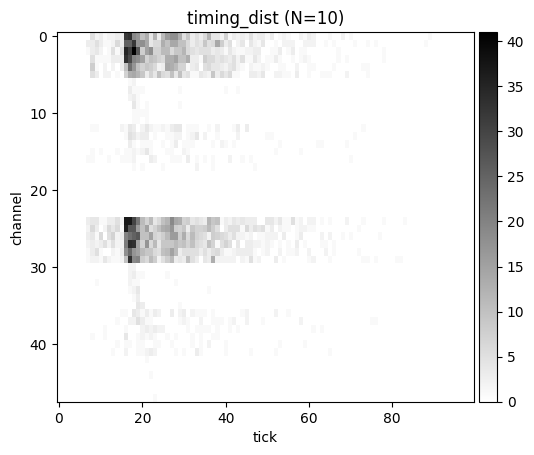

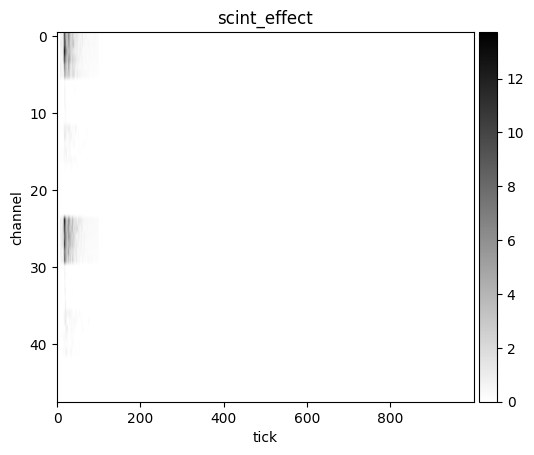

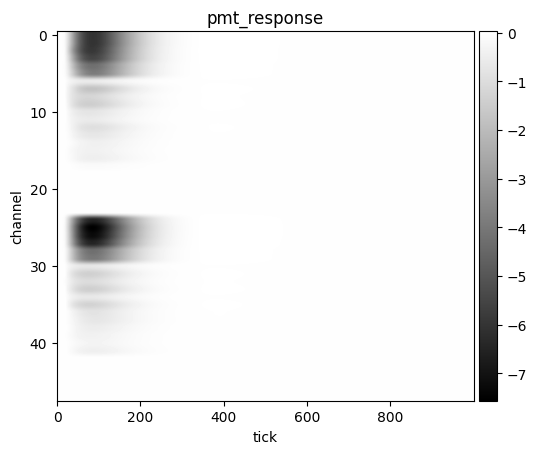

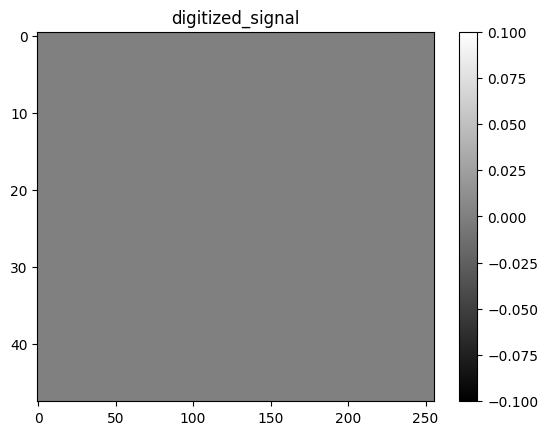

In [228]:
timing_dist, scint_effect, light_response, light_digit_signal = simulate_raw_waveform(4100)
plt.imshow(timing_dist, aspect="auto", cmap="gray_r")
plt.xlabel("tick")
plt.ylabel("channel")
plt.title("timing_dist (N=10)")
plt.colorbar(pad=0.01)
plt.show()
plt.imshow(scint_effect, aspect="auto", cmap="gray_r")
plt.title("scint_effect")
plt.xlabel("tick")
plt.ylabel("channel")
plt.colorbar(pad=0.01)
plt.show()
plt.imshow(light_response, aspect="auto", cmap="gray")
plt.title("pmt_response")
plt.xlabel("tick")
plt.ylabel("channel")
plt.colorbar(pad=0.01)
plt.show()

plt.imshow(light_digit_signal, aspect="auto", cmap="gray")
plt.colorbar()
plt.title("digitized_signal")
plt.show()